In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from keras.layers import LSTM, Dense
from keras.models import Sequential
from sklearn.metrics import roc_auc_score
from Vis import plot_loss, plot_roc
from Preprocessing import Preprocessing
from Preprocessing import Cols
import numpy as np
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.preprocessing import RobustScaler, StandardScaler
from pandas import DataFrame
from pandas import Series
import pandas as pd
from keras.layers import Dropout
# pandas.set_option('max_columns',10)

Using TensorFlow backend.


In [3]:
pre = Preprocessing()
X, y = pre.load_data(time_gap=300)

prepared dataset contains: per_stud_dataset + per_action_dataset_summ


In [4]:
per_action_dataset = pre.per_action_dataset
per_action_dataset.index = per_action_dataset.ITEST_id
per_action_dataset = per_action_dataset.drop("ITEST_id", axis=1)
per_action_dataset = per_action_dataset.drop(['assistmentId', 'problemId', 'assignmentId', 'actionId'], axis=1)

In [5]:
# show the seq of a sample student (id =9)
#per_action_dataset[per_action_dataset.index.get_level_values(0) ==9].head()

In [6]:
#truncating seq of each student and only considering his last 500 actions based on startTime feature
truncated_input = per_action_dataset.sort_values("startTime",ascending=False).groupby('ITEST_id').head(500)

In [7]:
# scaling dataset
scaler = RobustScaler()
X_scaled = scaler.fit_transform(truncated_input)
X_scaled = DataFrame(X_scaled, index=truncated_input.index, columns=truncated_input.columns)
#X_scaled[X_scaled.index.get_level_values(0) ==9].head()

In [8]:
# defining sequence length (or number of time-steps) for each student and batch-size
max_length_seq = 500

In [9]:
batch_size=10

In [10]:
# padding sequences to have a same length
X_padded = []
for stud_id, stud_seq in X_scaled.groupby(by='ITEST_id'):
    X_padded.append(stud_seq)
X_padded = sequence.pad_sequences(X_padded, max_length_seq, dtype='float64')

In [11]:
pd.set_option('max_columns',90)
# getting a sense about padded dataset
new_seq_ix = pd.Index(list(range(0,max_length_seq))* X_padded.shape[0], name="seq_ix")
ITEST_ix = pd.Index(np.repeat(sorted(X_scaled.index.get_level_values(0).unique()), max_length_seq), name='ITEST_id')
paddedData = DataFrame(X_padded.reshape(X_padded.shape[0]*X_padded.shape[1], -1), index=[ITEST_ix, new_seq_ix], columns=X_scaled.columns)
#paddedData[paddedData.index.get_level_values(0) == 27].head()

In [12]:
# creating label dataset with index as ITEST_id values
label_dataset = pre.label_dataset[['ITEST_id', 'isSTEM']]
label_dataset.index = label_dataset.ITEST_id
label_dataset = label_dataset.drop("ITEST_id", axis = 1)
#label_dataset

In [13]:
# join label with dataset to make sure we have a consistent dataset
# (of course before the training the label column will be droped from data)
X_with_label = paddedData.join(label_dataset)
#print(X_with_label.shape)
#X_with_label

In [14]:
y_prepared = X_with_label.groupby("ITEST_id").isSTEM.first().values
X_prepared = X_with_label.drop("isSTEM", axis=1)
X_prepared = X_prepared.values.reshape((-1, max_length_seq, X_prepared.shape[1]))
#print(X_prepared.shape)
#X_prepared

## Model

In [15]:
def create_LSTM_model(max_length_seq, feature_size):
    # create the LSTM network
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=(max_length_seq, feature_size)))
    model.add(LSTM(100, return_sequences=True))
    model.add(LSTM(100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [16]:
# splitting train/test data 
X_train, X_test, y_train,y_test = train_test_split(X_prepared,y_prepared, train_size=.99)

In [18]:
# Create model
model = create_LSTM_model(max_length_seq, X_train.shape[2])
history = model.fit(X_train, y_train, epochs=5, batch_size=batch_size, validation_split=0.33)

Train on 309 samples, validate on 153 samples
Epoch 1/5
309/309 [==============================] - 77s - loss: 0.5847 - acc: 0.7411 - val_loss: 0.5778 - val_acc: 0.7255
Epoch 2/5
309/309 [==============================] - 71s - loss: 0.5396 - acc: 0.7605 - val_loss: 0.5740 - val_acc: 0.7255
Epoch 3/5
309/309 [==============================] - 75s - loss: 0.5325 - acc: 0.7605 - val_loss: 0.5945 - val_acc: 0.7320
Epoch 4/5
309/309 [==============================] - 73s - loss: 0.5335 - acc: 0.7605 - val_loss: 0.6112 - val_acc: 0.7320
Epoch 5/5
309/309 [==============================] - 72s - loss: 0.4795 - acc: 0.7832 - val_loss: 0.6081 - val_acc: 0.7059


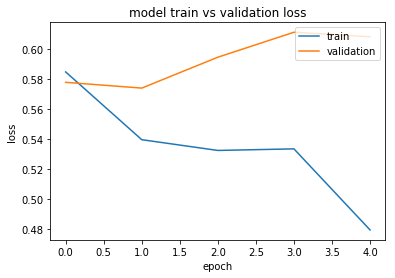

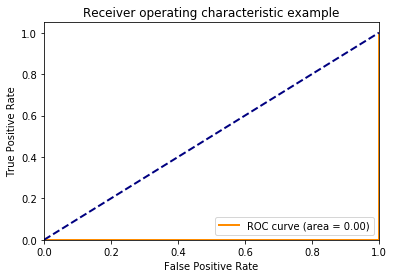

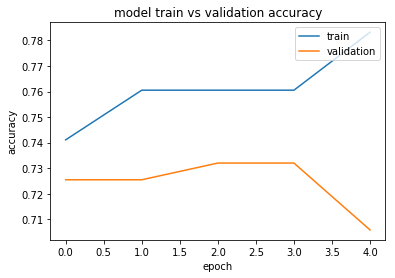

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 500, 100)          59200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 500, 100)          80400     
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 220,101
Trainable params: 220,101
Non-trainable params: 0
_________________________________________________________________
None
Test ROC Score: 0.000000
Test RMSE Score: 0.616359
Final Competition Score: 0.383641


In [20]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from Vis import plot_accuracy
# do prediction
y_pred = model.predict(X_test, batch_size=batch_size)

# calculating scores
roc_score = roc_auc_score(y_test, y_pred)
mse_score = mean_squared_error(y_test, y_pred)

# printing and plotting model and score information
plot_loss(history)
plot_roc(y_test, y_pred)
plot_accuracy(history)

print(model.summary())
print("Test ROC Score: %f" % roc_score)
print("Test RMSE Score: %f" % sqrt(mse_score))
print("Final Competition Score: %f" % (1 - sqrt(mse_score) + roc_score))

## EDA

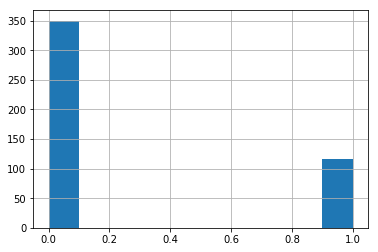

In [25]:
# see the dist. of labels: unbalanced labels!
X_with_label.groupby('ITEST_id').isSTEM.mean().hist()

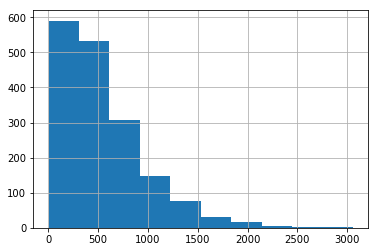

In [3]:
# number of actions for each student before summarization
pre.raw_dataset.groupby("ITEST_id").size().hist()